# IBSR_23:Brain Tissue Segmentation Using Deep Learning
Author(s): **Mohammad Imran Hossain, Muhammad Zain Amin**
<br>University of Girona, Spain
<br>Erasmus Mundus Joint Master Degree in Medical Imaging and Applications

# Necessary Libraries

In [49]:
# Import all the necessary libraries
import os
import cv2
import glob
import random
import tqdm 
import scipy.misc
import numpy as np
from tqdm import tqdm
import SimpleITK as sitk
from scipy import ndimage
from pathlib import Path
from matplotlib import pyplot as plt

import warnings

# Import Dataset
- **Load the train and validation dataset from the dirctory**

In [10]:
# Define the path of the train and validation dataset directory
TRAIN_DATA_PATH = Path('D:/Erasmus Mundus Masters/University of Girona/Medical Image Segmentation/IBSR_23_Brain_Tissue_Segmentation/Dataset/Training_Set')
VALID_DATA_PATH = Path('D:/Erasmus Mundus Masters/University of Girona/Medical Image Segmentation/IBSR_23_Brain_Tissue_Segmentation/Dataset/Validation_Set')

In [39]:
# Define a function to load image dataset from a directory
def bias_field_corrector(data_path):
    """
    Load image and label data from a specified directory path.

    Args:
    - image_size : Image dimensions (depth, height, width).
    - data_path  : Path of the directory containing image and label data.

    Returns:
    - images     :  List of images.
                           Shape: (num_images, depth, height, width, channels)
    - labels     :  List of labels.
                           Shape: (num_images, depth, height, width, channels)
    """
    # Count the number of images in the data path
    num_images = len(list(data_path.iterdir()))
    
    # Progress bar initialization
    with tqdm(total=num_images, desc='Preprocessing Progress') as pbar:
        idx = 0  
        # Loop through each image in the data path
        for image_path in data_path.iterdir():
            
            # Extract the image ID and define the image path
            image_id    = image_path.name  
            image_path  = data_path / image_id / f'{image_id}.nii.gz'  
            save_image_path = data_path / image_id / f'{image_id}_bias.nii.gz'
            
            # Read the image and convert into array
            inputImage  = sitk.ReadImage(str(image_path))
            maskImage   = sitk.OtsuThreshold(inputImage,0,1,200)
            inputImage  = sitk.Cast(inputImage,sitk.sitkFloat32)
            corrector   = sitk.N4BiasFieldCorrectionImageFilter();
            output      = corrector.Execute(inputImage,maskImage)

            sitk.WriteImage(output,save_image_path)

            idx += 1  
            pbar.update(1) 


bias_field_corrector(TRAIN_DATA_PATH)
bias_field_corrector(VALID_DATA_PATH)

Preprocessing Progress: 100%|███████████████████████████████████████████████████████████| 5/5 [08:35<00:00, 103.12s/it]


In [45]:
# Define a function to load image dataset from a directory
def load_data(image_size, data_path):
    """
    Load image and label data from a specified directory path.

    Args:
    - image_size : Image dimensions (depth, height, width).
    - data_path  : Path of the directory containing image and label data.

    Returns:
    - images     :  List of images.
                           Shape: (num_images, depth, height, width, channels)
    - labels     :  List of labels.
                           Shape: (num_images, depth, height, width, channels)
    """
    # Count the number of images in the data path
    num_images = len(list(data_path.iterdir()))
    images = np.zeros((num_images, *image_size, 1))
    
    # Progress bar initialization
    with tqdm(total=num_images, desc='Loading Progress') as pbar:
        idx = 0  
        # Loop through each image in the data path
        for image_path in data_path.iterdir():
            
            # Extract the image ID and define the image path
            image_id    = image_path.name  
            image_path  = data_path / image_id / f'{image_id}_bias.nii.gz'  
            
            # Read the image and convert into array
            image       = sitk.ReadImage(str(image_path))  
            image_array = sitk.GetArrayFromImage(image)
            image_array = image_array.reshape((*image_size, 1))

            # Insert loaded images and labels into arrays
            images[idx] = image_array
            
            pbar.update(1)  

    return images

# Define the image size
IMAGE_SIZE = (256, 128, 256)


# Read train and validation images and corresponding lables
train_images = load_data(IMAGE_SIZE, TRAIN_DATA_PATH)
valid_images = load_data(IMAGE_SIZE, VALID_DATA_PATH)



Loading Progress: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


In [46]:
train_images.shape

(10, 256, 128, 256, 1)

- **Display bias corrected train and validation images**

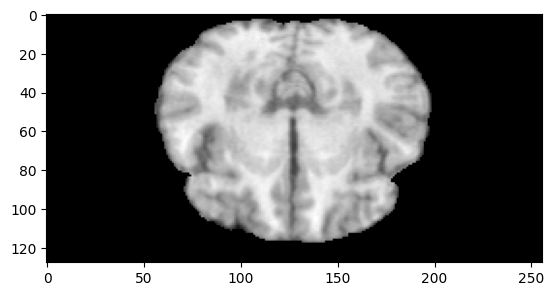

In [36]:
image = sitk.GetArrayFromImage(bias_corrected_train_images[0])  
plt.imshow(image[125,:,:], cmap='gray')

# Volumn Denosing

In [50]:
def anisodiff3(stack,niter=1,kappa=50,gamma=0.1,step=(1.,1.,1.),option=1,ploton=False):

    # ...you could always diffuse each color channel independently if you
    # really want
    if stack.ndim == 4:
        warnings.warn("Only grayscale stacks allowed, converting to 3D matrix")
        stack = stack.mean(3)

    # initialize output array
    stack    = stack.astype('float32')
    stackout = stack.copy()

    # initialize some internal variables
    deltaS = np.zeros_like(stackout)
    deltaE = deltaS.copy()
    deltaD = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    UD = deltaS.copy()
    gS = np.ones_like(stackout)
    gE = gS.copy()
    gD = gS.copy()

    # create the plot figure, if requested
    if ploton:
        import pylab as pl
        from time import sleep

        showplane = stack.shape[0]//2

        fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
        ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

        ax1.imshow(stack[showplane,...].squeeze(),interpolation='nearest')
        ih = ax2.imshow(stackout[showplane,...].squeeze(),interpolation='nearest',animated=True)
        ax1.set_title("Original stack (Z = %i)" %showplane)
        ax2.set_title("Iteration 0")

        fig.canvas.draw()

    for ii in range(niter):

        # calculate the diffs
        deltaD[:-1,: ,:  ] = np.diff(stackout,axis=0)
        deltaS[:  ,:-1,: ] = np.diff(stackout,axis=1)
        deltaE[:  ,: ,:-1] = np.diff(stackout,axis=2)

        # conduction gradients (only need to compute one per dim!)
        if option == 1:
            gD = np.exp(-(deltaD/kappa)**2.)/step[0]
            gS = np.exp(-(deltaS/kappa)**2.)/step[1]
            gE = np.exp(-(deltaE/kappa)**2.)/step[2]
        elif option == 2:
            gD = 1./(1.+(deltaD/kappa)**2.)/step[0]
            gS = 1./(1.+(deltaS/kappa)**2.)/step[1]
            gE = 1./(1.+(deltaE/kappa)**2.)/step[2]

        # update matrices
        D = gD*deltaD
        E = gE*deltaE
        S = gS*deltaS

        # subtract a copy that has been shifted 'Up/North/West' by one
        # pixel. don't as questions. just do it. trust me.
        UD[:] = D
        NS[:] = S
        EW[:] = E
        UD[1:,: ,: ] -= D[:-1,:  ,:  ]
        NS[: ,1:,: ] -= S[:  ,:-1,:  ]
        EW[: ,: ,1:] -= E[:  ,:  ,:-1]

        # update the image
        stackout += gamma*(UD+NS+EW)

        if ploton:
            iterstring = "Iteration %i" %(ii+1)
            ih.set_data(stackout[showplane,...].squeeze())
            ax2.set_title(iterstring)
            fig.canvas.draw()
            # sleep(0.01)

    return stackout


def denoise_volumes(in_volumes):

  n_loop = in_volumes.shape[0]

  out_volumes = np.zeros(in_volumes.shape)
  #print(out_volumes.shape)

  for i in range(0,n_loop,1):
    temp = in_volumes[i,:,:,:,:]
    temp = anisodiff3(temp,niter=10)
    temp = temp.reshape((*temp.shape, 1))
    out_volumes[i] = temp

  return out_volumes

In [51]:
denoised_train_images = denoise_volumes(train_images) 

C:\Users\hossa\AppData\Local\Temp\ipykernel_12708\3340494670.py:6: UserWarning: Only grayscale stacks allowed, converting to 3D matrix
  warnings.warn("Only grayscale stacks allowed, converting to 3D matrix")


In [52]:
denoised_train_images.shape

(10, 256, 128, 256, 1)

257.1174621582031

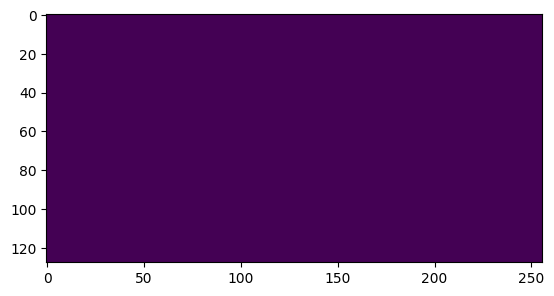

In [60]:
plt.imshow(denoised_train_images[4,200,:,:,:])
np.max(denoised_train_images)